In [207]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
from lib.optimizers import *
from lib.functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## Example functions

$$p \in \R^N = \R^3, \forall_{0 \leq i < M} \, x^{[i]} \in \R^K = \R^2, \, y^{[i]} \in \R$$

$$f : \R^K \times \R^N \to \R, \qquad f(x, p) = p_0 x_0 + p_1 x_1 + p_2 $$

$$ D_pf(x, p) = \left[\frac{\partial f}{\partial p_0}(x, p), \frac{\partial f}{\partial p_1}(x, p), \frac{\partial f}{\partial p_2}(x, p)\right]^T = [x_0, x_1, 1]^T$$

$$ R : \R^N \to \R^M, \qquad R(p) = \left[(f(x^{[i]}, p) - y^{[i]})^2\right]_{0 \leq i < M} $$

$$ D_pR(p) = \left[2(f(x^{[i]}, p) - y^{[i]})\frac{\partial f}{\partial p_j}(x^{[i]}, p)\right]_{0 \leq i < M, 0 \leq j < N}$$

In [209]:
xs = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
ys = np.array([1, 2, 3, 4])


def f(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return p[0] * x[0] + p[1] * x[1] + p[2]


def df(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([x[0], x[1], 1])


def residue(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    xs: np.ndarray,
    ys: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])

    return (fs - ys)**2


def residue_jacobian(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    df: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])
    dfs = np.array([df(x, p) for x in xs])

    return np.array([2 * (fs[i] - ys[i]) * dfs[i] for i in range(len(xs))])

In [210]:
def R_value(p: np.ndarray) -> np.ndarray:
    return residue(f, xs, ys, p)

def R_derivative(p: np.ndarray) -> np.ndarray:
    return residue_jacobian(f, df, ys, xs, p)

R = Function(R_value, R_derivative, 3, 4)

In [211]:
R_value(np.array([1, 1, 1]))

array([ 9, 16, 25, 36])

# TEST
# TODO remove later

In [212]:
M = 6
sin = Function(F=np.sin, DF=np.cos, M=1, N=1)
cos = Function(F=np.cos, DF=lambda x: -np.sin(x), M=1, N=1)
exp = Function(F=np.exp, DF=np.exp, M=1, N=1)
square = Function(F=lambda x: x**2, DF=lambda x: 2 * x, M=1, N=1)
norm = Function(F=np.linalg.norm, DF=lambda x: x / np.linalg.norm(x), M=M, N=1)
sum_ = Function(F=np.sum, DF=lambda _: np.ones(M), M=M, N=1)
proj = lambda k: Function(F=lambda x: x[k], DF=lambda _: np.eye(M)[k], M=M, N=1)
const = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(M), M=M, N=1)
mul_const = lambda c: Function(F=lambda x: c * x, DF=lambda _: np.array(c), M=1, N=1)

F1 = compose(proj(0), sin + compose(mul_const(2), cos))
F2 = compose(proj(1), cos)
F3 = compose(proj(2), 2 * exp)
F4 = compose(norm, sin, exp)
F5 = compose(sum_ + const(1), compose(exp, square))
F6 = compose(proj(5), sin, square, exp, cos)
F = stack(F1, F2, F3, F4, F5, F6)

p = np.array([np.pi / 3, np.pi / 4, 0, 3, -1, 5])
print(F(p))
print(F.differential(p))

[ 3.66025404e-01  7.07106781e-01  2.00000000e+00  8.00793746e-01
  3.47123586e+08 -8.05980153e-01]
[[-1.23205081e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -7.07106781e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.34941816e-01  1.01206362e-01  0.00000000e+00  3.86579828e-01
  -1.28859943e-01  6.44299713e-01]
 [ 6.94247171e+08  6.94247171e+08  6.94247171e+08  6.94247171e+08
   6.94247171e+08  6.94247171e+08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  8.07689852e-01]]


In [213]:
# p0 = np.array([21, 37, 42, 69, -420])
# p0 = np.ones(5)
p0 = np.random.rand(6)
max_iter = 10000
p0

array([0.51860337, 0.12409981, 0.48468639, 0.56248629, 0.34095023,
       0.73700631])

In [214]:
p, err = gradient_descent(F, p0, 0.001, max_iter)
p, err

(array([-7020.93174789, -7019.85722694, -7019.91538351, -7019.8271937 ,
        -7020.04829212, -7020.7108834 ]),
 0.4060354813331908)

In [215]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter)
p, err

Singular matrix encountered in 45-th iteration. Returning current point.


(array([  1.57078961,   7.85398163,  33.51570937,  36.92171872,
        -61.91122962,   0.73690488]),
 1.2608913079628957e+17)

In [216]:
optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=0.01, lambda_change=1.1)
)

In [217]:
p, err = optimizer.optimize(p0=p0, max_iter=max_iter, step_type="solve")
p, err

(array([ 1.47414356,  7.84172921, -4.95190932, -3.8778724 , -3.8778724 ,
         0.73610457]),
 0.3715222805512409)

In [218]:
p, err = optimizer.optimize(p0=p0, max_iter=max_iter, step_type="least_squares")
p, err

(array([ 1.47414356,  7.84172921, -4.95190932, -3.8778724 , -3.8778724 ,
         0.73610457]),
 0.37152228055124115)

In [219]:
p, err = optimizer.optimize(p0=p0, max_iter=max_iter, step_type="ridge")
p, err

(array([ 1.14416   ,  3.95651556, -2.61429886, -2.34394421, -2.34394421,
         0.60882528]),
 1.0875355479773774)

## Hyperparameters

In [ ]:
# p0 = np.random.randn(3)
p0 = np.array([1.5, 0.6, -3.14])
max_iter = 1000

## Gradient descent method

In [ ]:
p, err = gradient_descent(R, p0, 0.0001, max_iter)
print(f"{p=}, {err=}")

p=array([ 1.12693716,  0.63955052, -2.72738664]), err=2.0158093579792693


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([-0.32134843,  1.44513925,  3.21162694,  4.97811462])

## Gauss-Newton method

In [ ]:
p, err = gauss_newton(R, p0, max_iter, silent=True)
print(f"{p=}, {err=}")

Singular matrix encountered in 5-th iteration. Returning current point.
p=array([ 0.82308036,  0.21129464, -0.29066964]), err=0.003980691350191393


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([0.955   , 1.989375, 3.02375 , 4.058125])

## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [ ]:
lambda_param = 1e-3
optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)
p, err = optimizer.optimize(p0, max_iter)
print(f"{p=}, {err=}")

p=array([-0.07937187,  1.07977078, -1.08085736]), err=5.463312677507736e-07


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([0.99931233, 1.99971123, 3.00011014, 4.00050904])

In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([-0.07937187,  1.07977078, -1.08085736]), err=5.463312677507736e-07


In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
print(f"{p=}, {err=}")

p=array([-0.07647219,  1.07871259, -1.08481522]), err=1.7233163951545136e-05


### Test parameters

In [ ]:
lambda_params = [10**i for i in range(-10, 2)]
errors_levenberg_marquardt_constant_param = []
p0s = [np.random.randn(3) for _ in range(10)]

for lambda_param in lambda_params:
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, silent=True)
        errs.append(err)
    
    errors_levenberg_marquardt_constant_param.append(errs)

errors_gauss_newton = []
for p0 in p0s:
    p, err = gauss_newton(R=R, p0=p0, max_iter=max_iter, silent=True)
    errors_gauss_newton.append(err)

Singular matrix encountered in 15-th iteration. Returning current point.
Singular matrix encountered in 5-th iteration. Returning current point.
Singular matrix encountered in 4-th iteration. Returning current point.
Singular matrix encountered in 32-th iteration. Returning current point.
Singular matrix encountered in 42-th iteration. Returning current point.
Singular matrix encountered in 11-th iteration. Returning current point.
Singular matrix encountered in 0-th iteration. Returning current point.
Singular matrix encountered in 14-th iteration. Returning current point.
Singular matrix encountered in 34-th iteration. Returning current point.
Singular matrix encountered in 8-th iteration. Returning current point.


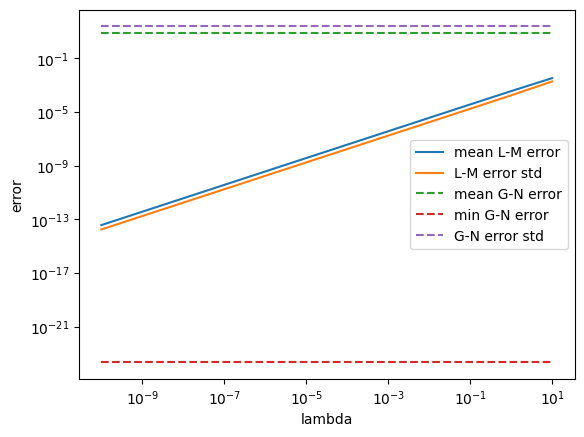

In [ ]:
errors_mean = np.mean(errors_levenberg_marquardt_constant_param, axis=1)
errors_std = np.std(errors_levenberg_marquardt_constant_param, axis=1)

errors_gn_mean = np.mean(errors_gauss_newton)
errors_gn_std = np.std(errors_gauss_newton)

plt.loglog(lambda_params, errors_mean, label="mean L-M error")
plt.loglog(lambda_params, errors_std, label="L-M error std")

plt.loglog(lambda_params, [errors_gn_mean] * len(lambda_params), label="mean G-N error", linestyle="--")
plt.loglog(lambda_params, [np.min(errors_gauss_newton)] * len(lambda_params), label="min G-N error", linestyle="--")
plt.loglog(lambda_params, [errors_gn_std] * len(lambda_params), label="G-N error std", linestyle="--")

plt.legend()
plt.xlabel("lambda")
plt.ylabel("error")
plt.show()

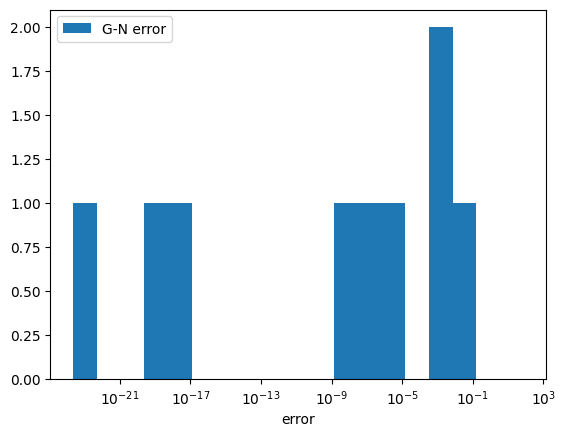

In [ ]:
logbins = np.logspace(np.log10(np.min(errors_gauss_newton)), np.log10(np.max(errors_gauss_newton)), 20)
plt.hist(errors_gauss_newton, bins=logbins, label="G-N error")
plt.xscale("log")
plt.xlabel("error")
plt.legend()
plt.show()

#### 2. Sequence $\lambda_k$ decrasing when error is decreasing, and increasing otherwise

In [ ]:
optimizer = LevenbergMarquardt(
    R=R,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(
        lambda0=0.1, lambda_change=2
    ),
)
p, err = optimizer.optimize(p0, max_iter)
print(f"{p=}, {err=}")

p=array([ 0.03282742,  0.96717258, -0.96717258]), err=5.0697667660620786e-20


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4.])

In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([ 0.03282742,  0.96717258, -0.96717258]), err=1.9968781409166757e-20


In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
print(f"{p=}, {err=}")

p=array([ 0.03284614,  0.96715308, -0.96715095]), err=2.107187031123506e-12
